Let's dig deeper into surface codes. We will take the example of a distance=4 surface code and apply a few decoding tests.

First, import a few common dependencies:

In [1]:
from matplotlib import pyplot as plt
from jupyter_plotter import plot_jupyter_figure
import pymatching

from circuit_generators import get_builtin_circuit, get_custom_circuit
from sampling_functions import create_task_sinter, generate_samples_sinter, get_variable_from_sample_sinter, plot_error_rate_sinter

# Also define the number of worker nodes here
n_worker_nodes = 8

Create tasks for the distance=4 surface code (built-in `rotated_memory_z` code):

In [2]:
n_samples = 1000000
decoders = ['pymatching']
distances = sorted([4])
rounds = sorted([1, 2, 4, 8, 12])
noise_levels = sorted([0.001, 0.0015, 0.003, 0.005, 0.01, 0.02])

tasks = [
  create_task_sinter(
    fcn_circuit_generator = get_builtin_circuit,
    args_circuit_generator = {
      "builtin_name": "surface_code:rotated_memory_z", "distance": d, "rounds": r,
      "after_reset_flip_probability": noise,
      "after_clifford_depolarization": noise,
      "before_round_data_depolarization": noise,
      "before_measure_flip_probability": noise,
      },
    json_metadata = {'distance': d, 'noise': noise, 'rounds': r}
  )
  for d in distances
  for r in rounds
  for noise in noise_levels
]

results = generate_samples_sinter(
  num_workers = n_worker_nodes,
  tasks = tasks,
  decoders = decoders,
  num_samples = n_samples,
)

Plot the logical error rates per shot and per round for the different rounds per distance:

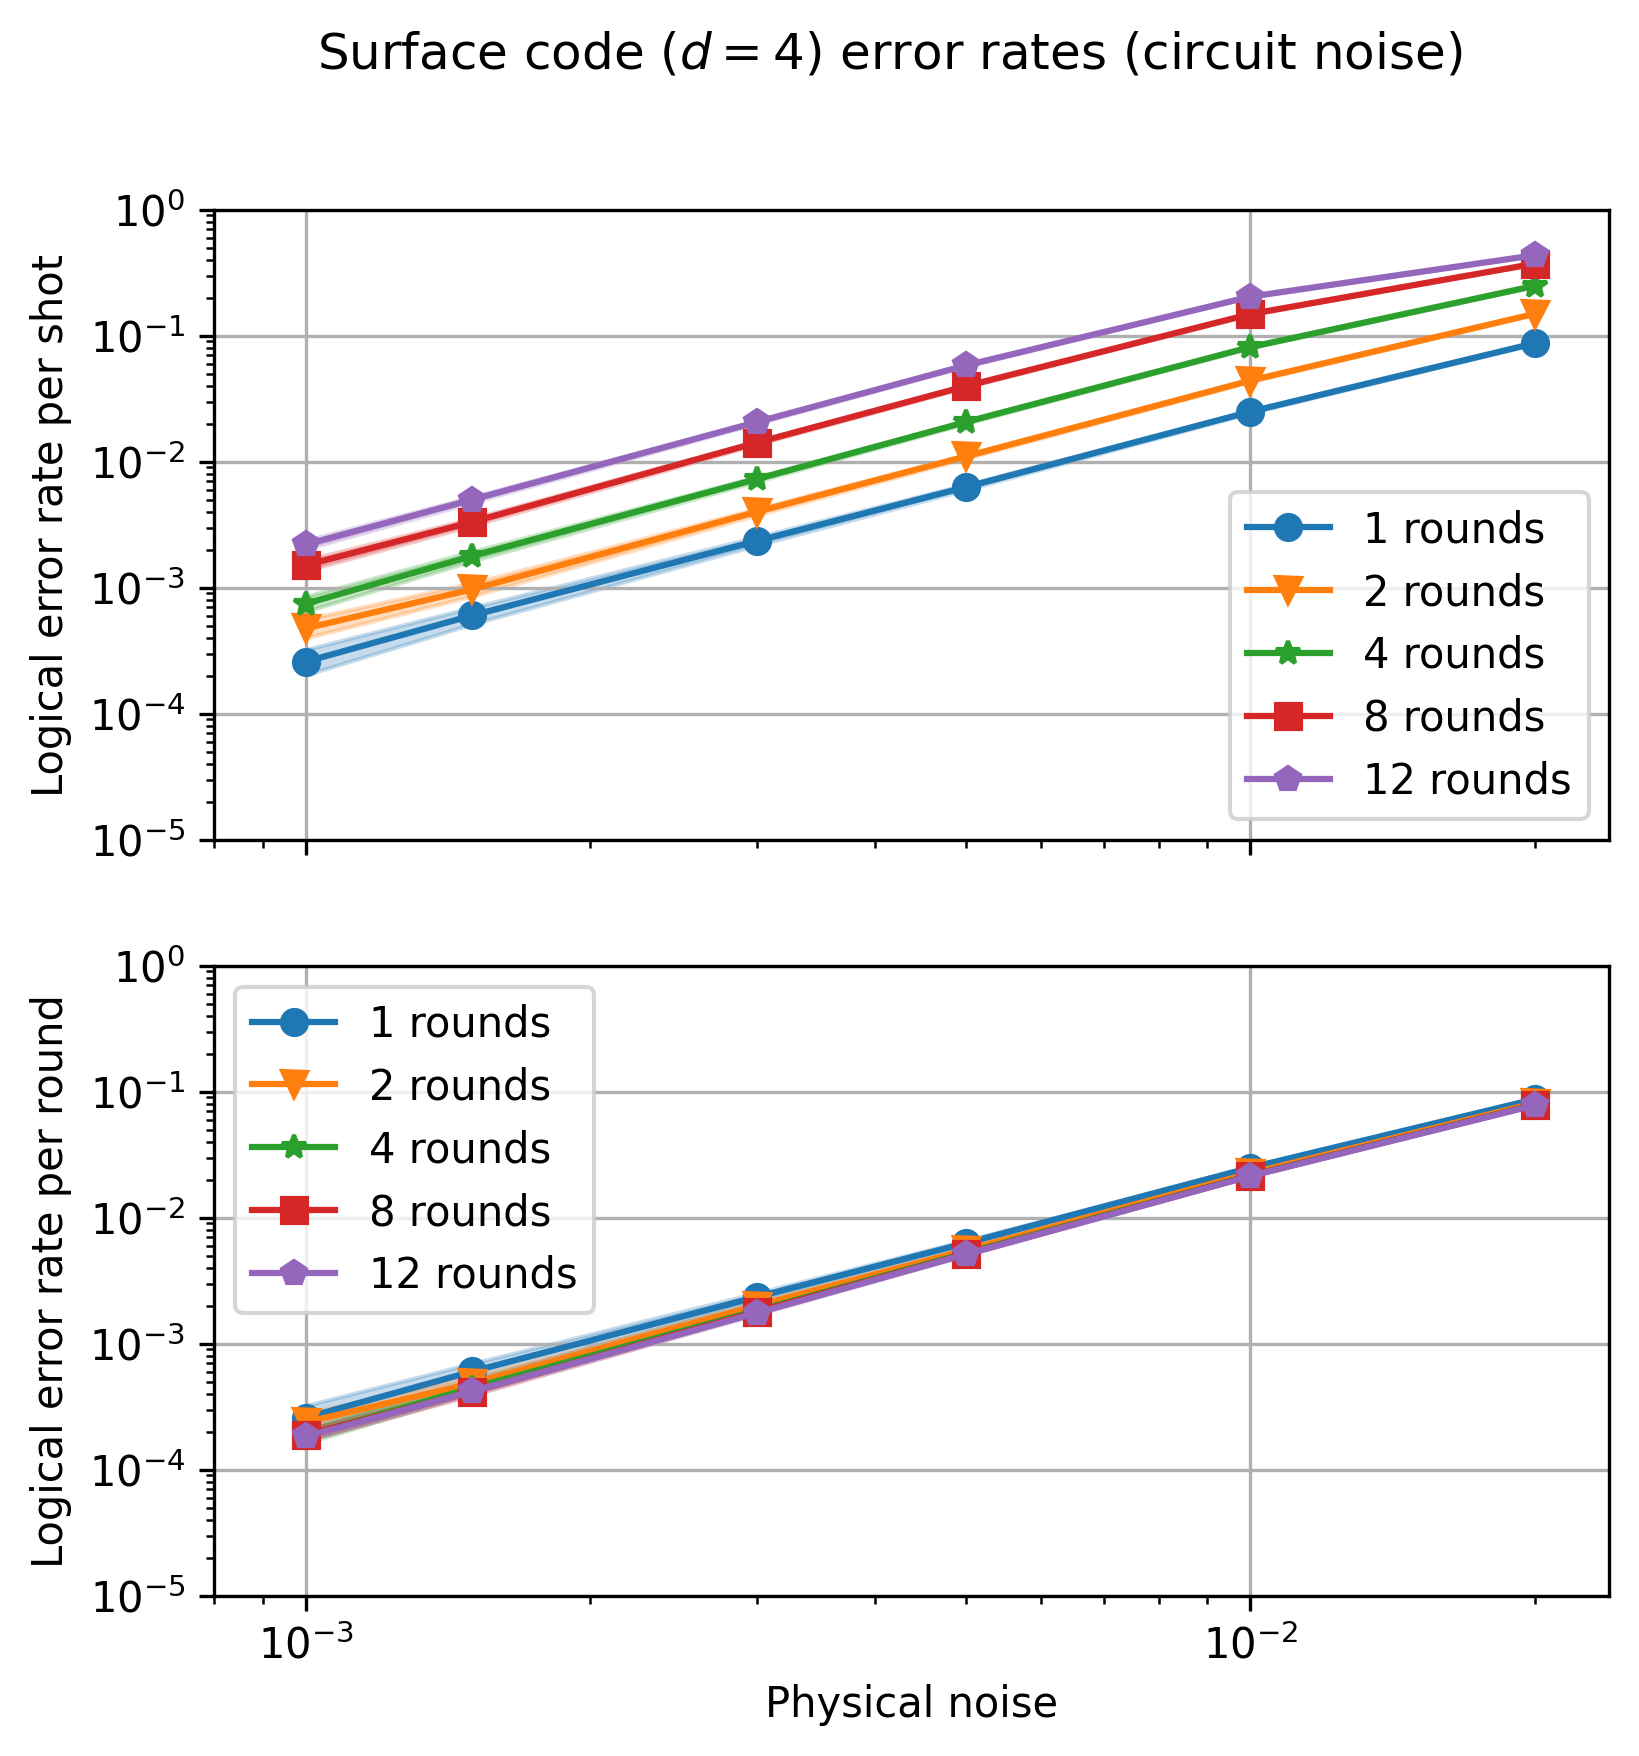

In [3]:
fig, (axl, axr) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
plot_label = "Surface code ($d=4$) error rates (circuit noise)"
group_labels = dict()
for r in rounds:
  group_labels[r] = f"{r} rounds"
plot_error_rate_sinter(
  axl, results, "noise", "Physical noise", "Logical error rate per shot",
  group_title="rounds", group_labels=group_labels,
  x_range=(noise_levels[0]*0.8, noise_levels[-1]*1.2), y_range=(1e-5, 1.)
)
plot_error_rate_sinter(
  axr, results, "noise", "Physical noise", "Logical error rate per round",
  group_title="rounds", group_labels=group_labels,
  x_range=(noise_levels[0]*0.8, noise_levels[-1]*1.2), y_range=(1e-5, 1.),
  failure_units_per_shot_func = lambda st, tt="rounds": get_variable_from_sample_sinter(st, tt)
)
axl.label_outer()
axr.label_outer()
fig.suptitle(plot_label)
fig.set_dpi(300)
plot_jupyter_figure(fig)

Error rate per round between 1-round measurements vs. 12 only seem to be different by ~30%. For now, pick simple 1-round measurements.

In [4]:
test_circuits = [ tasks[i].circuit for i in range(len(noise_levels)) ] # No need to remake the circuits, just pick those from the innermost for-loop

Let's try a different decoder algorithm, [BP+OSD using stim](https://github.com/oscarhiggott/stimbposd).

Note 1: The stim implementation is based on [ldpc](https://github.com/quantumgizmos/ldpc), which asks [this paper](https://doi.org/10.1103/PhysRevResearch.2.043423) to be cited.

Note 2: The speed of the `bposd` decoder run is slow (x <1/100) compared to pyMatching (24 minutes and still counting vs 9 s for 1000 shots).

Note 3 (after 30 minutes): Let's leave this for a longer day to run on its own. &#x23F3;

In [7]:
"""
from stimbposd import BPOSD, SinterDecoder_BPOSD
from stimbposd import sinter_decoders as sinter_decoders_bposd

# Refresh the tasks just in case task objects act funky
# Keep the circuits and corresponding noise levels
tasks = [
  create_task_sinter(
    fcn_circuit_generator = get_custom_circuit,
    args_circuit_generator = { "circuit": test_circuits[i] },
    json_metadata = {'noise': noise_levels[i]}
  )
  for i in range(len(noise_levels))
]

decoders = ['bposd']
results_with_bposd = generate_samples_sinter(
  num_workers = 15,
  tasks = tasks,
  decoders = decoders,
  num_samples = n_samples,
  custom_decoders = sinter_decoders_bposd
)
"""

'\nfrom stimbposd import BPOSD, SinterDecoder_BPOSD\nfrom stimbposd import sinter_decoders as sinter_decoders_bposd\n\n# Refresh the tasks just in case task objects act funky\n# Keep the circuits and corresponding noise levels\ntasks = [\n  create_task_sinter(\n    fcn_circuit_generator = get_custom_circuit,\n    args_circuit_generator = { "circuit": test_circuits[i] },\n    json_metadata = {\'noise\': noise_levels[i]}\n  )\n  for i in range(len(noise_levels))\n]\n\ndecoders = [\'bposd\']\nresults_with_bposd = generate_samples_sinter(\n  num_workers = 15,\n  tasks = tasks,\n  decoders = decoders,\n  num_samples = n_samples,\n  custom_decoders = sinter_decoders_bposd\n)\n'

Let's compare pyMatching predictions to NN with TensorFlow/Keras. First, import dependencies.

In [5]:
from utilities_tf import *
import numpy as np
from copy import deepcopy

2024-05-27 09:34:58.062130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 09:34:58.234024: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-27 09:34:58.234043: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-05-27 09:34:58.970188: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

Sample a detection events manually since we are going to use them in both pyMatching and TF.

In [6]:
detector_events = []
actual_flips = []
# The four lists below are for the training and testing data
detector_events_train = []
actual_flips_train = []
detector_events_test = []
actual_flips_test = []
i_noise = 0
for test_circuit in test_circuits:
  sampler = test_circuit.compile_detector_sampler(seed=12345)
  det_evts, flips = sampler.sample(1000000, separate_observables=True, bit_packed=True)
  detector_events.append(det_evts)
  actual_flips.append(flips)
  print("Number of flips in the circuit for noise probability p={}: {} / {} = {}".format(noise_levels[i_noise], np.sum(flips.reshape(-1,)), flips.shape[0], np.sum(flips.reshape(-1,))/flips.shape[0]))
  i_noise += 1

  # Split the data into training and testing sets
  det_evts_train, det_evts_test, flips_train, flips_test = split_data(features = det_evts, labels = flips, test_size=0.2)
  detector_events_train.append(det_evts_train)
  actual_flips_train.append(flips_train)
  detector_events_test.append(det_evts_test)
  actual_flips_test.append(flips_test)

Number of flips in the circuit for noise probability p=0.001: 15933 / 1000000 = 0.015933


TypeError: split_data() got an unexpected keyword argument 'features'

In [44]:
models_dense = []
models_qdense = []
models_qdense_after_pymatching = []
for i in range(len(noise_levels)):
  models_dense.append(
    build_sequential_dense_model(
      detector_events[i].shape[1], actual_flips[i].shape[1],
      [256, 256, 128, 64, 32],
      loss_fcn = "binary_crossentropy"
    )
  )
  models_qdense.append(
    build_sequential_qdense_model(
      detector_events[i].shape[1], actual_flips[i].shape[1],
      [(256, 8), (256, 8), (128, 8), (64, 8), (32, 8)],
      loss_fcn = "binary_crossentropy"
    )
  )
  models_qdense_after_pymatching.append(
    build_sequential_qdense_model(
      detector_events[i].shape[1]+1, actual_flips[i].shape[1],
      [(256, 8), (256, 8), (128, 8), (64, 8), (32, 8)],
      loss_fcn = "binary_crossentropy"
    )
  )

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_185 (Dense)           (None, 256)               768       
                                                                 
 dense_186 (Dense)           (None, 256)               65792     
                                                                 
 dense_187 (Dense)           (None, 128)               32896     
                                                                 
 dense_188 (Dense)           (None, 64)                8256      
                                                                 
 dense_189 (Dense)           (None, 32)                2080      
                                                                 
 dense_190 (Dense)           (None, 1)                 33        
                                                                 
Total params: 109825 (429.00 KB)
Trainable params: 10

Re-run pyMatching for these particular test_circuits and check how accuracy compares.

In [59]:
predictions_pymatching = []
for i in range(len(noise_levels)):
  detector_error_model = test_circuits[i].detector_error_model(decompose_errors=True)
  matcher = pymatching.Matching.from_detector_error_model(detector_error_model)
  prediction = matcher.decode_batch(detector_events[i], bit_packed_predictions=True, bit_packed_shots=True)
  prediction = (prediction>0)
  matches = (prediction != actual_flips[i])
  matches_flipped = matches*(actual_flips[i] != 0)
  matches_unflipped = matches*(actual_flips[i] == 0)
  n_data = actual_flips[i].shape[0]
  n_flips = np.sum(actual_flips[i].reshape(-1,) != 0)
  n_unflips = np.sum(actual_flips[i].reshape(-1,) == 0)
  n_matches = np.sum(matches)
  n_matches_flipped = np.sum(matches_flipped)
  n_matches_unflipped = np.sum(matches_unflipped)
  print(f"Prediction accuracy for p={noise_levels[i]}: {1.0 - n_matches/n_data:.6f}")
  print(f"- Flipped/unflipped accuracies: {1.0 - n_matches_flipped/n_flips:.6f} / {1.0 - n_matches_unflipped/n_unflips:.6f}")
  predictions_pymatching.append(prediction)

# Add the pyMatching predictions to detector_events data
detector_events_after_pymatching = []
detector_events_after_pymatching_train = []
detector_events_after_pymatching_test = []
for i in range(len(noise_levels)):
  det_evts = np.concatenate((detector_events[i], predictions_pymatching[i]), axis=1)
  detector_events_after_pymatching.append(det_evts)
  det_evts_train, det_evts_test, _, _ = split_data(features = det_evts, labels = actual_flips[i], test_size=0.2)
  detector_events_after_pymatching_train.append(det_evts_train)
  detector_events_after_pymatching_test.append(det_evts_test)
  assert(det_evts_train.shape[0] == detector_events_train[i].shape[0])

Prediction accuracy for p=0.001: 0.999767
- Flipped/unflipped rates: 0.994601 / 0.999851
Prediction accuracy for p=0.0015: 0.999426
- Flipped/unflipped rates: 0.991018 / 0.999629
Prediction accuracy for p=0.003: 0.997691
- Flipped/unflipped rates: 0.980755 / 0.998503
Prediction accuracy for p=0.005: 0.993523
- Flipped/unflipped rates: 0.963898 / 0.995899
Prediction accuracy for p=0.01: 0.975271
- Flipped/unflipped rates: 0.920838 / 0.983994
Prediction accuracy for p=0.02: 0.913196
- Flipped/unflipped rates: 0.818661 / 0.942948


Let's now run the TF models.

In [60]:
for i in range(len(noise_levels)):
  print(f"Training the model with Dense layers for noise probability p={noise_levels[i]}")
  history = models_dense[i].fit(detector_events_train[i], actual_flips_train[i], epochs=30, batch_size=100000, validation_split=0.2)
  test_model(models_dense[i], detector_events_train[i], actual_flips_train[i], detector_events_test[i], actual_flips_test[i])
  print(f"Training the model with QDense layers for noise probability p={noise_levels[i]}")
  history = models_qdense[i].fit(detector_events_train[i], actual_flips_train[i], epochs=30, batch_size=100000, validation_split=0.2)
  test_model(models_qdense[i], detector_events_train[i], actual_flips_train[i], detector_events_test[i], actual_flips_test[i])
  print(f"Training the model with QDense layers after pyMatching for noise probability p={noise_levels[i]}")
  history = models_qdense_after_pymatching[i].fit(detector_events_after_pymatching_train[i], actual_flips_train[i], epochs=30, batch_size=100000, validation_split=0.2)
  test_model(models_qdense_after_pymatching[i], detector_events_after_pymatching_train[i], actual_flips_train[i], detector_events_after_pymatching_test[i], actual_flips_test[i])

Training the model with Dense layers for noise probability p=0.001


Epoch 1/30
7/7 [==============================] - 10s 890ms/step - loss: 0.6666 - accuracy: 0.9769 - val_loss: 0.6351 - val_accuracy: 0.9842
Epoch 2/30
7/7 [==============================] - 5s 760ms/step - loss: 0.6099 - accuracy: 0.9840 - val_loss: 0.5583 - val_accuracy: 0.9842
Epoch 3/30
7/7 [==============================] - 7s 1s/step - loss: 0.5086 - accuracy: 0.9840 - val_loss: 0.4074 - val_accuracy: 0.9842
Epoch 4/30
7/7 [==============================] - 7s 964ms/step - loss: 0.3207 - accuracy: 0.9840 - val_loss: 0.1783 - val_accuracy: 0.9842
Epoch 5/30
7/7 [==============================] - 6s 878ms/step - loss: 0.1148 - accuracy: 0.9840 - val_loss: 0.0548 - val_accuracy: 0.9842
Epoch 6/30
7/7 [==============================] - 8s 1s/step - loss: 0.0481 - accuracy: 0.9840 - val_loss: 0.0430 - val_accuracy: 0.9842
Epoch 7/30
7/7 [==============================] - 8s 1s/step - loss: 0.0419 - accuracy: 0.9840 - val_loss: 0.0378 - val_accuracy: 0.9842
Epoch 8/30
7/7 [============

Save all models so that we can use them later when we restart.

In [61]:
for i in range(len(noise_levels)):
  models_dense[i].save(f"models_dense_{i}.keras")
  models_qdense[i].save(f"models_qdense_{i}.keras")
  models_qdense_after_pymatching[i].save(f"models_qdense_after_pymatching_{i}.keras")

Predict all of the models and compare.

In [62]:
for i in range(len(noise_levels)):
  print(f"Sequential model with Dense layers (p={noise_levels[i]}):")
  predict_model(models_dense[i], detector_events[i], actual_flips[i])
  print(f"Sequential model with QDense layers (p={noise_levels[i]}):")
  predict_model(models_qdense[i], detector_events[i], actual_flips[i])
  print(f"Sequential model with QDense layers after pyMatching (p={noise_levels[i]}):")
  predict_model(models_qdense_after_pymatching[i], detector_events_after_pymatching[i], actual_flips[i])

  matches = (predictions_pymatching[i] != actual_flips[i])
  matches_flipped = matches*(actual_flips[i] != 0)
  matches_unflipped = matches*(actual_flips[i] == 0)
  n_data = actual_flips[i].shape[0]
  n_flips = np.sum(actual_flips[i].reshape(-1,) != 0)
  n_unflips = np.sum(actual_flips[i].reshape(-1,) == 0)
  n_matches = np.sum(matches)
  n_matches_flipped = np.sum(matches_flipped)
  n_matches_unflipped = np.sum(matches_unflipped)
  print(f"pyMatching (p={noise_levels[i]}):")
  print(f"Prediction accuracy for p={noise_levels[i]}: {1.0 - n_matches/n_data:.6f}")
  print(f"- Flipped/unflipped accuracies: {1.0 - n_matches_flipped/n_flips:.6f} / {1.0 - n_matches_unflipped/n_unflips:.6f}")

Sequential model with Dense layers (p=0.001):
10/10 [==============================] - 2s 222ms/step
Prediction accuracy: 0.015928
Sequential model with QDense layers (p=0.001):
10/10 [==============================] - 14s 1s/step
Prediction accuracy: 0.996305
Sequential model with QDense layers after pyMatching (p=0.001):
10/10 [==============================] - 14s 1s/step
Prediction accuracy: 0.999558
pyMatching (p=0.001):
Prediction accuracy for p=0.001: 0.999767
- Flipped/unflipped accuracies: 0.994601 / 0.999851
Sequential model with Dense layers (p=0.0015):
10/10 [==============================] - 3s 238ms/step
Prediction accuracy: 0.023604
Sequential model with QDense layers (p=0.0015):
10/10 [==============================] - 14s 1s/step
Prediction accuracy: 0.994049
Sequential model with QDense layers after pyMatching (p=0.0015):
10/10 [==============================] - 16s 1s/step
Prediction accuracy: 0.998620
pyMatching (p=0.0015):
Prediction accuracy for p=0.0015: 0.999426

Future work! &#x26A1;